# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

### Introduction: Business Problem

The city of Cape Town sees a relatively high amount of domestic migration from South African citizens moving in from other parts of the country. This is because the city is perceived as having a higher standard of living than other cities and better employment opportunities. The beautiful natural surroundings also serve as a significant draw card for domestic migrants. The majority of these migrants are recently graduated individuals and young professionals who are able to move to a new city because they have greater freedom to do so. There are a number of factors that a typical young person may consider when moving into a new neighbourhood. For the purpose of this analysis we will assume that the two most important factors these individuals consider are the following:

•	The type of eateries that exist around the neighbourhood.

•	The number of nightlife spots that are available within a short distance

We will therefore create a map that young people can use to decide which neighbourhood they want to move into based on the above mentioned factors. For the purpose of this analysis we will also only consider neighborhoods within the districts/boroughs of: Atlantic Seaboard, City Bowl, and Southern Suburbs because these form the economic hub of the city where all our main venues of interest are located.


In [44]:
#import pandas Library
import pandas as pd
import requests

import numpy as np # library to handle data in a vectorized manner

#!conda install -c conda-forge geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist


### Download and join City bowl, Southern suburbs and Atlantic seaboard Neighbourhoods dataset

In [45]:
#wikipedia page with list of Neighbourhoods in Cape town city bowl, southern surburbs and atlantic seaboard
wikipedia_link='https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs'

In [46]:
#Our wikipedia page has multiple tables so we need to specify which table to use as well as which row to use as the header

#Atlantic seaboard neighbourhoods are in the 1st table
atlseaboard_surb = pd.read_html(wikipedia_link, header = 0)[0]

#City bowl neighbourhoods are in the 3rd table
citybowl_surb = pd.read_html(wikipedia_link, header = 0)[2]

#Southern suburb neighbourhoods are in the 7th table
south_surb = pd.read_html(wikipedia_link, header = 0)[6]

#drop postal code and street code columns
citybowl_surb.drop('Postal Code', axis = 1, inplace = True)
atlseaboard_surb.drop('Postal Code', axis = 1, inplace = True)
south_surb.drop('Postal Code', axis = 1, inplace = True)

citybowl_surb.drop('Street Code', axis = 1, inplace = True)
atlseaboard_surb.drop('Street Code', axis = 1, inplace = True)
south_surb.drop('Street Code', axis = 1, inplace = True)

#Rename suburb column
citybowl_surb.rename(columns={'Suburb':'Neighbourhood'}, inplace=True)
atlseaboard_surb.rename(columns={'Suburb':'Neighbourhood'}, inplace=True)
south_surb.rename(columns={'Suburb':'Neighbourhood'}, inplace=True)

#Create column on each dataframe to indicate which area neighbourhood belongs to
citybowl_surb['Area'] = 'City Bowl'
atlseaboard_surb['Area'] = 'Atlantic Seaboard'
south_surb['Area'] = 'Southern Suburbs'

#Join both df's
cpt_df = [citybowl_surb, atlseaboard_surb, south_surb]
cpt_df = pd.concat(cpt_df)

cpt_df.reset_index(inplace = True)
cpt_df.drop('index', axis = 1, inplace = True)

cpt_df

,Neighbourhood,Area
0,Bo-Kaap (Malay Quarter),City Bowl
1,Devil's Peak Estate,City Bowl
2,De Waterkant,City Bowl
3,Foreshore,City Bowl
4,Gardens,City Bowl
5,Higgovale,City Bowl
6,Lower Vrede (District Six),City Bowl
7,Oranjezicht,City Bowl
8,Salt River,City Bowl
9,Schotsche Kloof,City Bowl


Clean the Data frame

In [47]:
#Rename some Neighbourhoods with brackets and apostrophe

cpt_df.loc[0, 'Neighbourhood'] = 'Bo-Kaap'
cpt_df.loc[1, 'Neighbourhood'] = 'Devils Peak Estate'
cpt_df.loc[13, 'Neighbourhood'] = 'Walmer Estate'
cpt_df.loc[14, 'Neighbourhood'] = 'Woodstock'
cpt_df.loc[15, 'Neighbourhood'] = 'Zonnebloem'

#Zonnebloem and Lower vrede both refer to the same area (District 6). Drop Lower Vrede
cpt_df = cpt_df[cpt_df.Neighbourhood != 'Lower Vrede (District Six)']

#The same goes for Schotse Kloof and Bo-Kaap. Drop Schotse Kloof
cpt_df = cpt_df[cpt_df.Neighbourhood != 'Schotse Kloof (Malay Quarter)']

#drop Kreupelbosch and SouthField as they are part of Meadowridge and Plumstead respectively
cpt_df = cpt_df[cpt_df.Neighbourhood != 'Kreupelbosch']
cpt_df = cpt_df[cpt_df.Neighbourhood != 'SouthField']

cpt_df

,Neighbourhood,Area
0,Bo-Kaap,City Bowl
1,Devils Peak Estate,City Bowl
2,De Waterkant,City Bowl
3,Foreshore,City Bowl
4,Gardens,City Bowl
5,Higgovale,City Bowl
7,Oranjezicht,City Bowl
8,Salt River,City Bowl
9,Schotsche Kloof,City Bowl
10,Tamboerskloof,City Bowl


### Append GPS coords for each Neighbourhood

The CSV files citybowl_gps, southern_suburbs_gps and atlantic_seaboard_gps contain the gps co-ords

In [48]:
#download atlantic seaboard and city bowl coordinates csv
citybowl_gps = pd.read_csv("https://raw.githubusercontent.com/njabsm/Coursera_Capstone/master/citybowl_gps.csv")
atlseaboard_gps = pd.read_csv("https://raw.githubusercontent.com/njabsm/Coursera_Capstone/master/atlantic_seaboard_gps.csv")
southern_gps = pd.read_csv("https://raw.githubusercontent.com/njabsm/Coursera_Capstone/master/southern_suburbs_gps.csv")

#Rename suburb column
southern_gps.rename(columns={'Suburb':'Neighbourhood'}, inplace=True)

#Join the gps dataframes
gps_df = [citybowl_gps, atlseaboard_gps, southern_gps]
gps_df = pd.concat(gps_df)
gps_df.drop('Street Code', axis = 1, inplace = True)

#Append GPS coords to the neighbourhood df
cpt_df = cpt_df.merge(gps_df, left_on='Neighbourhood', right_on='Neighbourhood')

cpt_df


,Neighbourhood,Area,latitude,longitude
0,Bo-Kaap,City Bowl,-33.9216,18.4150
1,Devils Peak Estate,City Bowl,-33.9370,18.4321
2,De Waterkant,City Bowl,-33.9154,18.4194
3,Foreshore,City Bowl,-33.9222,18.4410
4,Gardens,City Bowl,-33.9353,18.4083
5,Higgovale,City Bowl,-33.9401,18.3992
6,Oranjezicht,City Bowl,-33.9413,18.4128
7,Salt River,City Bowl,-33.9268,18.4721
8,Tamboerskloof,City Bowl,-33.9281,18.4024
9,University Estate,City Bowl,-33.9386,18.4521


### Create a map of Cape Town with neighborhoods superimposed on top.

##### Use geopy library to get the latitude and longitude values of CPT.

In [49]:
import folium # map rendering library

address = 'Cape Town, Western Cape'

geolocator = Nominatim(user_agent="cpt")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of CPT are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of CPT are -33.928992, 18.417396.


##### Now use folium to generate map

In [50]:
# create map of New York using latitude and longitude values
map_cpt = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(cpt_df['latitude'], cpt_df['longitude'], cpt_df['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cpt)  
    
map_cpt

We'll now use the Foursquare API to explore the food venues around neighbourhoods and segment them using k-means

#### Define Foursquare Credentials and Version

In [51]:
CLIENT_ID = 'PRJAIQD3LQLVGX52CIFSNBAPAKIJBRENGRBPJ31GQG20PNPS' # your Foursquare ID
CLIENT_SECRET = 'VMYHBMTD0QSLPV0RK4DQPCWPTOIXEUBAAVFGGHN1K1NY0KIJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

The function below gets the top 100 venues around a neighbourhood

In [52]:
import requests # library to handle requests

def getNearbyVenues(names, latitudes, longitudes, radius, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let's retrieve the top 100 venues in each neighbourhood

In [53]:
cpt_venues = getNearbyVenues(names=cpt_df['Neighbourhood'],
                                   latitudes=cpt_df['latitude'],
                                   longitudes=cpt_df['longitude'],
                                   radius = 500
                                  )

Bo-Kaap
Devils Peak Estate
De Waterkant
Foreshore
Gardens
Higgovale
Oranjezicht
Salt River
Tamboerskloof
University Estate
Vredehoek
Walmer Estate
Woodstock
Zonnebloem
Bakoven
Bantry Bay
Camps Bay
Clifton
Fresnaye
Green Point
Hout Bay
Imizamo Yethu
Llandudno
Mouille Point
Sea Point
Three Anchor Bay
Bergvliet
Bishopscourt
Claremont
Constantia
Lansdowne
Diep River
Harfield Village
Heathfield
Kenilworth
Kenwyn
Kirstenhof
Meadowridge
Mowbray
Ndabeni
Newlands
Observatory
Pinelands
Plumstead
Retreat
Rondebosch
Rondebosch East
Rosebank
Steenberg
Tokai
Wynberg


In [54]:
cpt_venues.head()
print('CPT neighbourhoods have {} unique venue categories and {} venues in total.'.format(len(cpt_venues['Venue Category'].unique()),cpt_venues.shape[0]))
cpt_venues.head()

CPT neighbourhoods have 133 unique venue categories and 588 venues in total.


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bo-Kaap,-33.9216,18.415,The Gin Bar,-33.922733,18.417150,Cocktail Bar
1,Bo-Kaap,-33.9216,18.415,Honest Chocolate Café,-33.922730,18.417156,Café
2,Bo-Kaap,-33.9216,18.415,Bocca,-33.922334,18.416673,Italian Restaurant
3,Bo-Kaap,-33.9216,18.415,Hilton Cape Town City Centre,-33.921651,18.415785,Hotel
4,Bo-Kaap,-33.9216,18.415,Charango,-33.922008,18.417215,Restaurant


Now I extract all the food venues in each neighborhood. Food venue categories are chosen according to foursquare definition: https://developer.foursquare.com/docs/resources/categories

In [55]:
food_cat = ["Restaurant", "Steakhouse", "Meat", "Breakfast Spot", "Bakery", "Bistro", "Burger", "Ice Cream"
            , "Pie", "Diner", "Pastry", "Pizza", "Fish", "Food", "Donut", "Gastropub", "Salad", "Sandwich", "Deli"]

cpt_food = cpt_venues[cpt_venues['Venue Category'].str.contains('|'.join(food_cat))].reset_index()

cpt_food.drop('index', axis = 1, inplace = True)

print('The CPT neighbourhoods have {} food venues in total.'.format(cpt_food.shape[0]))
cpt_food.head()

The CPT neighbourhoods have 233 food venues in total.


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bo-Kaap,-33.9216,18.415,Bocca,-33.922334,18.416673,Italian Restaurant
1,Bo-Kaap,-33.9216,18.415,Charango,-33.922008,18.417215,Restaurant
2,Bo-Kaap,-33.9216,18.415,Clarke's Bar & Dining Room,-33.922284,18.417040,New American Restaurant
3,Bo-Kaap,-33.9216,18.415,Jason Bakery,-33.924538,18.414449,Bakery
4,Bo-Kaap,-33.9216,18.415,Easy Tiger Burger Bar,-33.922307,18.417054,Burger Joint


Let's analyse each neighbourhood and determine what's the number of unique food categories in each

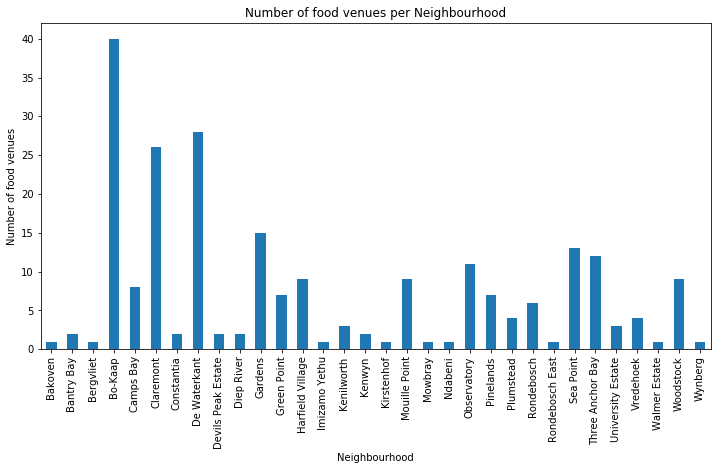

In [56]:
cpt_food_grouped = cpt_food.groupby('Neighbourhood').count()

cpt_food_grouped['Venue Category'].plot(kind='bar', figsize=(12, 6), legend = False)

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Number of food venues') # add y-label to the plot
plt.title('Number of food venues per Neighbourhood') # add title to the plot

plt.show()

In [57]:
print('There are {} unique venue categories. And {} food venues in total'.format(len(cpt_food['Venue Category'].unique()), cpt_food.shape[0]))

There are 42 unique venue categories. And 233 food venues in total


In [58]:
cpt_onehot = pd.get_dummies(cpt_food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cpt_onehot['Neighbourhood'] = cpt_food['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [cpt_onehot.columns[-1]] + list(cpt_onehot.columns[:-1])
cpt_onehot = cpt_onehot[fixed_columns]

cpt_onehot.head()

,Neighbourhood,African Restaurant,Asian Restaurant,Bakery,Bistro,Breakfast Spot,Burger Joint,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,...,Restaurant,Sandwich Place,Seafood Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Bo-Kaap,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bo-Kaap,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Bo-Kaap,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bo-Kaap,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bo-Kaap,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Let's drop the venue category "Restaurant" because it does not tell us about the type of food served there.

In [59]:
cpt_onehot.drop('Restaurant', axis = 1, inplace = True)

cpt_onehot.head()

,Neighbourhood,African Restaurant,Asian Restaurant,Bakery,Bistro,Breakfast Spot,Burger Joint,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,...,Portuguese Restaurant,Sandwich Place,Seafood Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Bo-Kaap,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bo-Kaap,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bo-Kaap,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bo-Kaap,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bo-Kaap,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category

In [60]:
cpt_grouped = cpt_onehot.groupby('Neighbourhood').mean().reset_index()
cpt_grouped.head()

,Neighbourhood,African Restaurant,Asian Restaurant,Bakery,Bistro,Breakfast Spot,Burger Joint,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,...,Portuguese Restaurant,Sandwich Place,Seafood Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Bakoven,0.00,0.000,0.000,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,1.000,0.000,0.00,0.000,0.0,0.000,0.0
1,Bantry Bay,0.00,0.000,0.000,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.000,0.500,0.000,0.000,0.00,0.000,0.0,0.000,0.0
2,Bergvliet,0.00,0.000,0.000,0.0,1.000,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.000,0.00,0.000,0.0,0.000,0.0
3,Bo-Kaap,0.05,0.025,0.025,0.0,0.025,0.1,0.0,0.0,0.025,...,0.0,0.025,0.025,0.075,0.025,0.05,0.025,0.0,0.025,0.0
4,Camps Bay,0.00,0.000,0.000,0.0,0.125,0.0,0.0,0.0,0.000,...,0.0,0.000,0.125,0.000,0.000,0.00,0.000,0.0,0.000,0.0


#### I'll now create a dataframe which shows the 5 most common food venue category in each neighbourhood
First create a function to sort the venues in descending order.

In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now to create the dataframe

In [62]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = cpt_grouped['Neighbourhood']

for ind in np.arange(cpt_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cpt_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bakoven,Steakhouse,Vietnamese Restaurant,Cuban Restaurant,Food Truck,Food & Drink Shop
1,Bantry Bay,Seafood Restaurant,Deli / Bodega,Vietnamese Restaurant,Cuban Restaurant,Food Truck
2,Bergvliet,Breakfast Spot,Vietnamese Restaurant,Deli / Bodega,Food Truck,Food & Drink Shop
3,Bo-Kaap,Burger Joint,Steakhouse,Indian Restaurant,Ethiopian Restaurant,Tapas Restaurant
4,Camps Bay,Pizza Place,Gastropub,Deli / Bodega,Breakfast Spot,Seafood Restaurant


#### k-Means clustering of Neighbourhoods

In [63]:
# set number of clusters
kclusters = 3

cpt_grouped_clustering = cpt_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cpt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
Clus_lables = kmeans.labels_
Clus_lables[0:10]



array([2, 0, 0, 0, 0, 0, 0, 0, 1, 2], dtype=int32)

Let's check if all our neighbourhoods have food venues

In [64]:
print('There are {} neighbourhoods with food venues.'.format(len(cpt_food['Neighbourhood'].unique())))
print('CPT has a total of {} neighbourhoods'.format(len(cpt_df['Neighbourhood'].unique())))

There are 32 neighbourhoods with food venues.
CPT has a total of 51 neighbourhoods


Now to insert the cluster label into the original dataframe and merge with the sorted dataset we've already created

In [65]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', Clus_lables)

#Only choose Neighbourhoods with food venues
Neighs_with_food_venues = cpt_food['Neighbourhood'].unique()
cpt_merged = cpt_df[cpt_df['Neighbourhood'].str.contains('|'.join(Neighs_with_food_venues))].reset_index()
cpt_merged.drop('index', axis = 1, inplace = True)

# merge neighbourhoods_venues_sorted with cpt_df to add latitude/longitude for each neighborhood
cpt_merged = cpt_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

cpt_merged.head() # check the last columns!

,Neighbourhood,Area,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bo-Kaap,City Bowl,-33.9216,18.4150,0,Burger Joint,Steakhouse,Indian Restaurant,Ethiopian Restaurant,Tapas Restaurant
1,Devils Peak Estate,City Bowl,-33.9370,18.4321,1,Italian Restaurant,Vietnamese Restaurant,Deli / Bodega,Food Truck,Food & Drink Shop
2,De Waterkant,City Bowl,-33.9154,18.4194,0,Sushi Restaurant,Italian Restaurant,African Restaurant,Mediterranean Restaurant,Fast Food Restaurant
3,Gardens,City Bowl,-33.9353,18.4083,0,Italian Restaurant,Mediterranean Restaurant,Vietnamese Restaurant,French Restaurant,Bakery
4,University Estate,City Bowl,-33.9386,18.4521,0,Caribbean Restaurant,Mediterranean Restaurant,Vietnamese Restaurant,Deli / Bodega,Food Truck


We'll know create another column to display the top 3 food venues in each neighbourhood. This column will be used as a pop up label in our Map 

In [66]:
cpt_merged['Top Three'] = cpt_merged[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']].apply(lambda x: ', '.join(x), axis=1)
cpt_merged.head()

,Neighbourhood,Area,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Top Three
0,Bo-Kaap,City Bowl,-33.9216,18.4150,0,Burger Joint,Steakhouse,Indian Restaurant,Ethiopian Restaurant,Tapas Restaurant,"Burger Joint, Steakhouse, Indian Restaurant"
1,Devils Peak Estate,City Bowl,-33.9370,18.4321,1,Italian Restaurant,Vietnamese Restaurant,Deli / Bodega,Food Truck,Food & Drink Shop,"Italian Restaurant, Vietnamese Restaurant, Del..."
2,De Waterkant,City Bowl,-33.9154,18.4194,0,Sushi Restaurant,Italian Restaurant,African Restaurant,Mediterranean Restaurant,Fast Food Restaurant,"Sushi Restaurant, Italian Restaurant, African ..."
3,Gardens,City Bowl,-33.9353,18.4083,0,Italian Restaurant,Mediterranean Restaurant,Vietnamese Restaurant,French Restaurant,Bakery,"Italian Restaurant, Mediterranean Restaurant, ..."
4,University Estate,City Bowl,-33.9386,18.4521,0,Caribbean Restaurant,Mediterranean Restaurant,Vietnamese Restaurant,Deli / Bodega,Food Truck,"Caribbean Restaurant, Mediterranean Restaurant..."


Now to visualize the clusters on a map

In [67]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, top3 in zip(cpt_merged['latitude'], cpt_merged['longitude'], cpt_merged['Neighbourhood'], cpt_merged['Cluster Labels'], cpt_merged['Top Three']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '\n' + str(top3), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine resulting Clusters

Cluster 0

In [68]:
cpt_merged.loc[cpt_merged['Cluster Labels'] == 0, cpt_merged.columns[[0] + [1] + list(range(5, cpt_merged.shape[1]))]]

,Neighbourhood,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Top Three
0,Bo-Kaap,City Bowl,Burger Joint,Steakhouse,Indian Restaurant,Ethiopian Restaurant,Tapas Restaurant,"Burger Joint, Steakhouse, Indian Restaurant"
2,De Waterkant,City Bowl,Sushi Restaurant,Italian Restaurant,African Restaurant,Mediterranean Restaurant,Fast Food Restaurant,"Sushi Restaurant, Italian Restaurant, African ..."
3,Gardens,City Bowl,Italian Restaurant,Mediterranean Restaurant,Vietnamese Restaurant,French Restaurant,Bakery,"Italian Restaurant, Mediterranean Restaurant, ..."
4,University Estate,City Bowl,Caribbean Restaurant,Mediterranean Restaurant,Vietnamese Restaurant,Deli / Bodega,Food Truck,"Caribbean Restaurant, Mediterranean Restaurant..."
6,Walmer Estate,City Bowl,Fast Food Restaurant,Vietnamese Restaurant,Gastropub,Food Truck,Food & Drink Shop,"Fast Food Restaurant, Vietnamese Restaurant, G..."
7,Woodstock,City Bowl,Seafood Restaurant,African Restaurant,Mexican Restaurant,Fast Food Restaurant,Breakfast Spot,"Seafood Restaurant, African Restaurant, Mexica..."
9,Bantry Bay,Atlantic Seaboard,Seafood Restaurant,Deli / Bodega,Vietnamese Restaurant,Cuban Restaurant,Food Truck,"Seafood Restaurant, Deli / Bodega, Vietnamese ..."
10,Camps Bay,Atlantic Seaboard,Pizza Place,Gastropub,Deli / Bodega,Breakfast Spot,Seafood Restaurant,"Pizza Place, Gastropub, Deli / Bodega"
11,Green Point,Atlantic Seaboard,Gastropub,Food Truck,Bakery,Sushi Restaurant,Burger Joint,"Gastropub, Food Truck, Bakery"
13,Mouille Point,Atlantic Seaboard,Asian Restaurant,Food,Sushi Restaurant,Steakhouse,Sandwich Place,"Asian Restaurant, Food, Sushi Restaurant"


Cluster 1

In [69]:
cpt_merged.loc[cpt_merged['Cluster Labels'] == 1, cpt_merged.columns[[0] + [1] + list(range(5, cpt_merged.shape[1]))]]

,Neighbourhood,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Top Three
1,Devils Peak Estate,City Bowl,Italian Restaurant,Vietnamese Restaurant,Deli / Bodega,Food Truck,Food & Drink Shop,"Italian Restaurant, Vietnamese Restaurant, Del..."
5,Vredehoek,City Bowl,Italian Restaurant,Bistro,Vietnamese Restaurant,Deli / Bodega,Food Truck,"Italian Restaurant, Bistro, Vietnamese Restaurant"
23,Kirstenhof,Southern Suburbs,Italian Restaurant,Vietnamese Restaurant,Deli / Bodega,Food Truck,Food & Drink Shop,"Italian Restaurant, Vietnamese Restaurant, Del..."


Cluster 2

In [70]:
cpt_merged.loc[cpt_merged['Cluster Labels'] == 2, cpt_merged.columns[[0] + [1] + list(range(5, cpt_merged.shape[1]))]]

,Neighbourhood,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Top Three
8,Bakoven,Atlantic Seaboard,Steakhouse,Vietnamese Restaurant,Cuban Restaurant,Food Truck,Food & Drink Shop,"Steakhouse, Vietnamese Restaurant, Cuban Resta..."
12,Imizamo Yethu,Atlantic Seaboard,Thai Restaurant,Vietnamese Restaurant,Cuban Restaurant,Food Truck,Food & Drink Shop,"Thai Restaurant, Vietnamese Restaurant, Cuban ..."
19,Diep River,Southern Suburbs,Bakery,Steakhouse,Vietnamese Restaurant,Deli / Bodega,Food Truck,"Bakery, Steakhouse, Vietnamese Restaurant"
20,Harfield Village,Southern Suburbs,Thai Restaurant,Steakhouse,Bakery,Sushi Restaurant,Fast Food Restaurant,"Thai Restaurant, Steakhouse, Bakery"
24,Mowbray,Southern Suburbs,Mexican Restaurant,Vietnamese Restaurant,Deli / Bodega,Food Truck,Food & Drink Shop,"Mexican Restaurant, Vietnamese Restaurant, Del..."
28,Plumstead,Southern Suburbs,Thai Restaurant,Fish & Chips Shop,Steakhouse,Seafood Restaurant,Vietnamese Restaurant,"Thai Restaurant, Fish & Chips Shop, Steakhouse"


Let's create a dataframe to illustrate the 1st Most Common venue in each cluster

In [71]:
cpt_merged_3 = cpt_merged[['Cluster Labels','1st Most Common Venue']]
cpt_merged_3['Count'] = 1
clus_grouped = cpt_merged_3.groupby(['Cluster Labels', '1st Most Common Venue']).sum()#.reset_index()

clus_grouped

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Count
Cluster Labels 1st Most Common Venue       
0              Asian Restaurant           1
               Bakery                     1
               Breakfast Spot             1
               Burger Joint               1
               Caribbean Restaurant       1
               Fast Food Restaurant       2
               Food & Drink Shop          1
               French Restaurant          1
               Gastropub                  2
               Indian Restaurant          1
               Italian Restaurant         3
               Mexican Restaurant         1
               Pizza Place                1
               Seafood Restaurant         2
               Steakhouse                 1
               Sushi Restaurant           1
               Vietnamese Restaurant      2
1              Italian Restaurant         3
2              Bakery                     1
               Mexican Restaurant         1
               Steakhouse                 1
               Thai Restaurant            3

Let's view the above dataframe in a bar chart

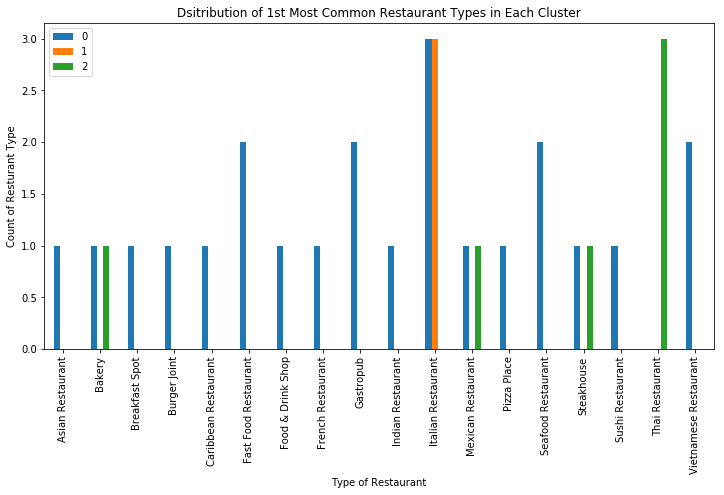

In [72]:
clus_grouped.unstack(level=0).plot(kind='bar', figsize=(12, 6))

plt.xlabel('Type of Restaurant') # add to x-label to the plot
plt.ylabel('Count of Resturant Type') # add y-label to the plot
plt.title('Dsitribution of 1st Most Common Restaurant Types in Each Cluster') # add title to the plot
plt.legend(['0', '1', '2'])

plt.show()

#### Choropleth Map
We'll now create a Choropleth Map to display the number of nightlife spots per ward in the city of cape town

First let's download the csv file suburb_ward.csv which shows which ward each suburb belongs to.

In [73]:
suburb_ward = pd.read_csv("https://raw.githubusercontent.com/njabsm/Coursera_Capstone/master/suburb_ward.csv")
suburb_ward.head()

,Neighbourhood,Ward
0,Bakoven,54
1,Bantry Bay,54
2,Bergvliet,73
3,Bishopscourt,62
4,Bo-Kaap,77


Now I extract all the Nightlife venues in each neighborhood. Nightlife venue categories are chosen according to foursquare definition: https://developer.foursquare.com/docs/resources/categories

Let first fetch all venues within a 900m radius

In [74]:
cpt_venues = getNearbyVenues(names=cpt_df['Neighbourhood'],
                                   latitudes=cpt_df['latitude'],
                                   longitudes=cpt_df['longitude'],
                                   radius = 900
                                  )

Bo-Kaap
Devils Peak Estate
De Waterkant
Foreshore
Gardens
Higgovale
Oranjezicht
Salt River
Tamboerskloof
University Estate
Vredehoek
Walmer Estate
Woodstock
Zonnebloem
Bakoven
Bantry Bay
Camps Bay
Clifton
Fresnaye
Green Point
Hout Bay
Imizamo Yethu
Llandudno
Mouille Point
Sea Point
Three Anchor Bay
Bergvliet
Bishopscourt
Claremont
Constantia
Lansdowne
Diep River
Harfield Village
Heathfield
Kenilworth
Kenwyn
Kirstenhof
Meadowridge
Mowbray
Ndabeni
Newlands
Observatory
Pinelands
Plumstead
Retreat
Rondebosch
Rondebosch East
Rosebank
Steenberg
Tokai
Wynberg


In [75]:
nightlife_cat = ["Bar", "Beer Garden", "Pub", "Speakeasy", "Brewery", "Night Market", "Lounge", "Nightclub", "Other Nightlife"]

cpt_nightlife = cpt_venues[cpt_venues['Venue Category'].str.contains('|'.join(nightlife_cat))].reset_index()

cpt_nightlife.drop('index', axis = 1, inplace = True)

print('The CPT neighbourhoods have {} nightlife venues in total.'.format(cpt_nightlife.shape[0]))
cpt_nightlife.head()

The CPT neighbourhoods have 96 nightlife venues in total.


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bo-Kaap,-33.9216,18.415,The Gin Bar,-33.922733,18.417150,Cocktail Bar
1,Bo-Kaap,-33.9216,18.415,Love Thy Neighbor,-33.921587,18.417270,Beer Garden
2,Bo-Kaap,-33.9216,18.415,Tjing Tjing Rooftop Bar,-33.922360,18.418772,Cocktail Bar
3,Bo-Kaap,-33.9216,18.415,Aces 'n Spades,-33.921385,18.420006,Bar
4,Bo-Kaap,-33.9216,18.415,Hank's Olde Irish,-33.922207,18.415692,Irish Pub


In [76]:
cpt_nightlife_grouped = cpt_nightlife.groupby('Neighbourhood').count()
cpt_nightlife_grouped.head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Bo-Kaap,15,15,15,15,15,15
Camps Bay,3,3,3,3,3,3
Claremont,6,6,6,6,6,6
Clifton,2,2,2,2,2,2
De Waterkant,16,16,16,16,16,16


In [77]:
cpt_nightlife_grouped.drop('Neighbourhood Latitude', axis = 1, inplace = True)
cpt_nightlife_grouped.drop('Neighbourhood Longitude', axis = 1, inplace = True)
cpt_nightlife_grouped.drop('Venue', axis = 1, inplace = True)
cpt_nightlife_grouped.drop('Venue Latitude', axis = 1, inplace = True)
cpt_nightlife_grouped.drop('Venue Longitude', axis = 1, inplace = True)
cpt_nightlife_grouped.head()

,Venue Category
Neighbourhood,
Bo-Kaap,15
Camps Bay,3
Claremont,6
Clifton,2
De Waterkant,16


Let's plot the dataframe above in a bar chart

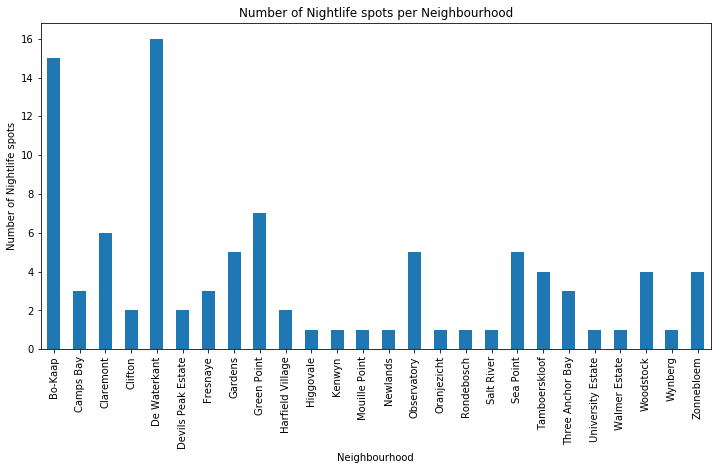

In [78]:
cpt_nightlife_grouped.plot(kind='bar', figsize=(12, 6), legend = False)

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Number of Nightlife spots') # add y-label to the plot
plt.title('Number of Nightlife spots per Neighbourhood') # add title to the plot

plt.show()

Now let merge cpt_nightlife_grouped with suburb_ward

In [84]:
ward_nightlife = suburb_ward.join(cpt_nightlife_grouped, on='Neighbourhood')
ward_nightlife.head()

,Neighbourhood,Ward,Venue Category
0,Bakoven,54,NaN
1,Bantry Bay,54,NaN
2,Bergvliet,73,NaN
3,Bishopscourt,62,NaN
4,Bo-Kaap,77,15.0


Let's drop the Neighbourhood column and replace NaN by 0 and group by ward to create a dataframe which shows the number of nightlife spots per ward

In [80]:
ward_nightlife.drop('Neighbourhood', axis = 1, inplace = True)
ward_nightlife.fillna(0, inplace=True)
ward_nightlife.rename(columns={'Venue Category':'No. of Nightlife Spots'}, inplace=True)
ward_nightlife = ward_nightlife.groupby('Ward').sum()
ward_nightlife.reset_index(inplace=True)

#need to convert to string because our JSON boundary file has the ward field stored as text
ward_nightlife['Ward'] = ward_nightlife.Ward.astype(str)
ward_nightlife

,Ward,No. of Nightlife Spots
0,53,0.0
1,54,13.0
2,57,7.0
3,58,2.0
4,59,8.0
5,60,1.0
6,62,1.0
7,68,0.0
8,71,0.0
9,73,0.0


Let's import the JSON with ward boundaries for our Choropleth map

In [38]:
cpt_ward_geo = r'https://raw.githubusercontent.com/njabsm/Coursera_Capstone/master/cpt-geojson.json' # geojson file

Now let's create the Foliu map from before but with the choropleth oveerlayed as well

In [42]:
# create map
map_cpt = folium.Map(location=[latitude, longitude], zoom_start=12)

    # create a numpy array of length 6 and has linear spacing from the minium total No. of Nightlife Spots to the maximum total No. of Nightlife Spots
threshold_scale = np.linspace(ward_nightlife['No. of Nightlife Spots'].min(), ward_nightlife['No. of Nightlife Spots'].max(), 6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

map_cpt.choropleth(
    geo_data=cpt_ward_geo,
    data=ward_nightlife,
    columns=['Ward', 'No. of Nightlife Spots'],
    key_on='feature.properties.name_4',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='No. of Nightlife Spot'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, top3 in zip(cpt_merged['latitude'], cpt_merged['longitude'], cpt_merged['Neighbourhood'], cpt_merged['Cluster Labels'], cpt_merged['Top Three']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '\n' + str(top3), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_cpt)
    
map_cpt

### Conclusion
The choropleth map created successfully achieves the goal of using data analytics to assist a young person moving into Cape Town decide which neighbourhood to move into based on:

•	The type of eateries that exist around the neighbourhood.

•	The number of nightlife spots that are available within a short distance 
